# WEAVE Fiber Positioner: Toy problems

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Explore geometric constraints, generate synthetic targets

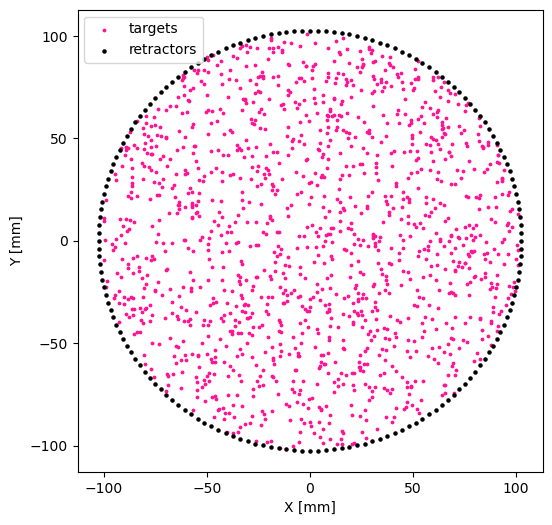

In [61]:
def rand_targets(R, n):
    """
    R = radius of disc
    n = number of targets to generate
    """
    p, q = np.random.uniform(0,1, size=(2, n)) # random numbers between 0 & 1, size (2, n)
    r = R * np.sqrt(p)
    theta = 2*np.pi*q

    return r * np.cos(theta), r * np.sin(theta)
    
# Specs
n_retractors = 168
r = 102.5 # mm, half of 205mm field
angles = np.linspace(0, 2*np.pi, n_retractors, endpoint=False) # placement of fibres
button_r = 4.5 # mm

# Synthetic targets
n_targets = 1400

x,y = rand_targets(r, n_targets)
plt.figure(figsize=(6,6))
plt.scatter(x,y, s=3, c='deeppink', label='targets')
plt.scatter(r*np.cos(angles), r*np.sin(angles), c='k', s=5, label='retractors')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.legend()

## Visualizing fibre assignments

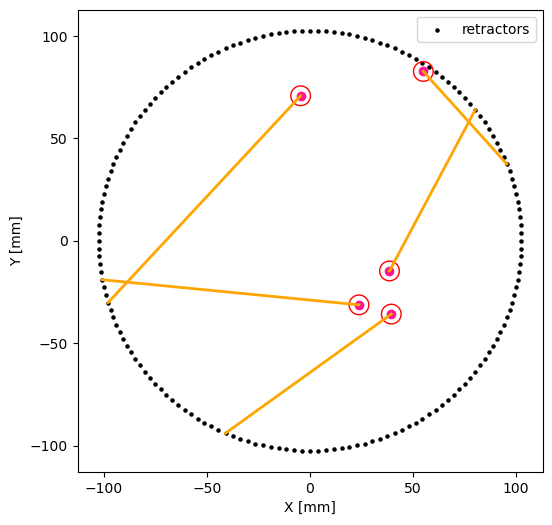

In [71]:
# Specs
n_retractors = 168
r = 102.5 # mm, half of 205mm field
button_r = 4.5 # mm

# Retractor positions
angles = np.linspace(0, 2*np.pi, n_retractors, endpoint=False) # placement of fibres
retractor_x = r * np.cos(angles)
retractor_y = r * np.sin(angles)

# Synthetic targets
n_targets = 1400
target_x,target_y = rand_targets(r, n_targets)

# Visualize fibers, random assignment
i_ls = np.random.randint(0,n_targets, size=5) # IDs of 5 random targets
j_ls = np.random.randint(0,n_retractors,size=5)
tx,ty = target_x[i_ls], target_y[i_ls]
plt.figure(figsize=(6,6))
plt.scatter(r*np.cos(angles), r*np.sin(angles), c='k', s=5, label='retractors')
plt.plot([retractor_x[j_ls], tx], [retractor_y[j_ls], ty], 'orange', lw=2)
plt.scatter(tx,ty, c='deeppink')
plt.scatter(tx,ty, marker='o', facecolors='none', edgecolors='r', s=200)
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.legend()

## Patrol areas

Model 3 fibres from each retractor, each at a different level -> a different REACH
Let each fibre only be allowed to bend 14 degrees.

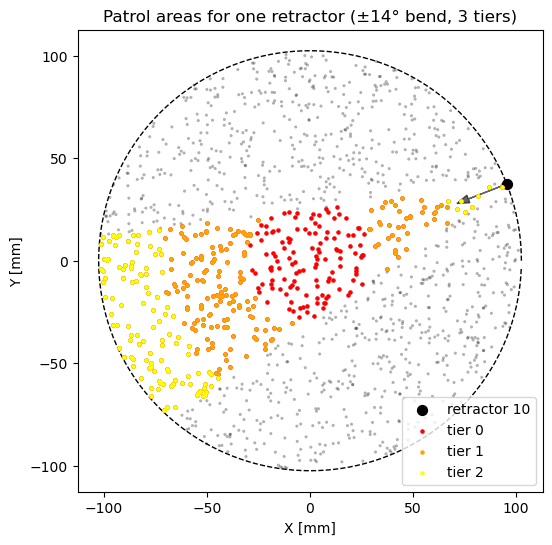

In [99]:
# Specs
n_retractors = 168
r = 102.5 # mm, half of 205mm field
button_r = 4.5 # mm

# Retractor positions
angles = np.linspace(0, 2*np.pi, n_retractors, endpoint=False) # placement of fibres
retractor_x = r * np.cos(angles)
retractor_y = r * np.sin(angles)

# Synthetic targets
# n_targets = 1400
# target_x,target_y = rand_targets(r, n_targets)

# VISUALIZE PATROL AREA
phi_max = np.deg2rad(14)  # max bend angle
reach = [1,0.7,0.3]  # fraction of r that each tier can reach
cols = ['red', 'orange', 'yellow'
]

# Visualize for random given retractor_id
retractor_id = 10
retractor_x, retractor_y = r * np.cos(angles[retractor_id]), r * np.sin(angles[retractor_id])
norm_dir_inward = -np.array([retractor_x, retractor_y]) / np.sqrt(retractor_x**2 + retractor_y**2)

n_targets = 1400
px,py = rand_targets(r, n_targets)

# Vector from retractore to target wrt normal at retractor
vx = px - retractor_x 
vy = py - retractor_y
v_len = np.sqrt(vx**2 + vy**2)
vx /= v_len
vy /= v_len
ang = np.arccos(vx * norm_dir_inward[0] + vy * norm_dir_inward[1]) # angle between two unit vectorsy is arccos of their dot product

# Plot
plt.figure(figsize=(6,6))
plt.plot(r * np.cos(angles), r * np.sin(angles), 'k--', lw=1)
plt.scatter(retractor_x, retractor_y, s=50, c='k', label=f'retractor {retractor_id}')
plt.arrow(retractor_x, retractor_y, 20*norm_dir_inward[0], 20*norm_dir_inward[1], head_width=4, head_length=6, 
          fc='k', ec='k', alpha=0.6)

for tier in range(3):
    min_r = (1 - reach[tier]) * r
    allowed = (np.sqrt(px**2 + py**2) >= min_r) & (ang <= phi_max)
    plt.scatter(px[allowed], py[allowed], s=5, c=cols[tier], label=f'tier {tier}', zorder=10)

plt.scatter(px,py, c='k', edgecolor='none', alpha=0.3, s=5)

plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.title('Patrol areas for one retractor (±14° bend, 3 tiers)')
plt.legend()
plt.show()


## Rules:
Buttons cannot overlap


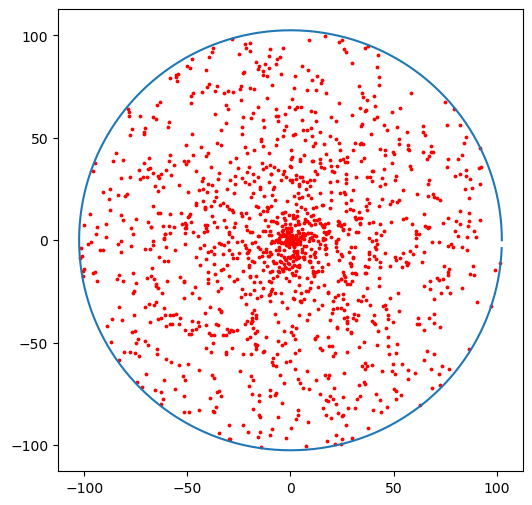

In [32]:
n_retractors = 168
r = 102.5 # mm, half of 205mm field
angles = np.linspace(0, 2*np.pi, n_retractors, endpoint=False)

# 1400 synthetic targets
n_targets = 1400
t_dist = np.random.uniform(0,r, size=n_targets)
t_phi = np.random.uniform(0,2*np.pi, size=n_targets)
t_x = t_dist * np.cos(t_phi)
t_y = t_dist * np.sin(t_phi)

x = r * np.cos(angles)
y = r * np.sin(angles)
plt.figure(figsize=(6,6))
plt.scatter(t_x, t_y, c='r', s=3)
plt.plot(x,y)


SA v1 (button-only): assigned=1, priority10=1, energy=0.1000
NS v1 (button-only): assigned=11, priority10=3, energy=8.3000


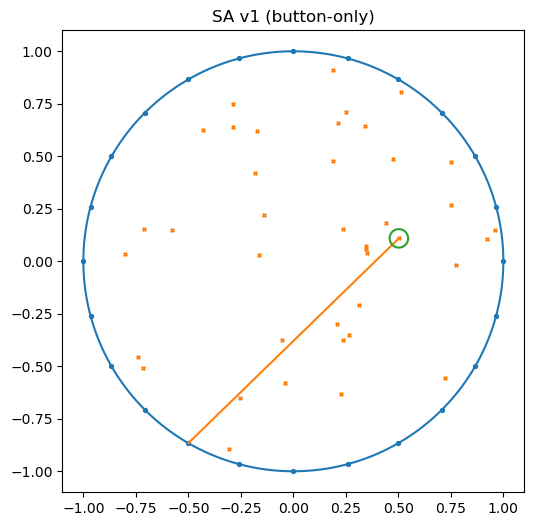

SA v2 (button + fibre-button): assigned=1, priority10=1, energy=0.1000
NS v2 (button + fibre-button): assigned=9, priority10=5, energy=4.5000


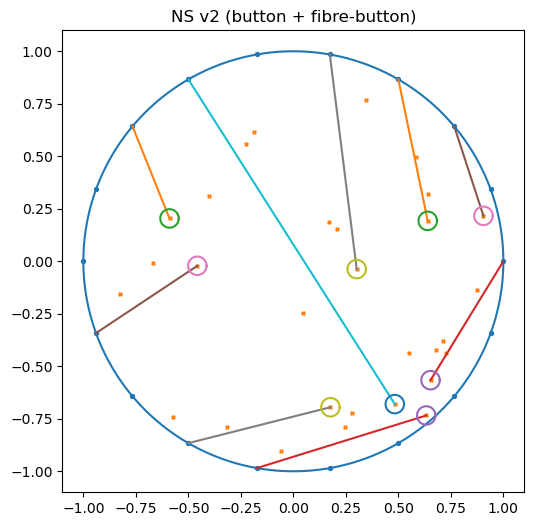

In [45]:
# Fast demo: two simple toy setups
#   Version 1: Only button-button constraints (larger N, faster)
#   Version 2: Button-button + fibre-button constraints (smaller N)
#
# Both compare Simulated Annealing (SA) vs. a minimal Nested Sampling (NS) variant.

import math
from dataclasses import dataclass
from typing import List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt

PLATE_R = 1.0
BUTTON_R = 0.044
rng = np.random.default_rng(11)


def rand_points_in_disc(n, r=PLATE_R):
    u = rng.random(n)
    rr = r * np.sqrt(u)
    theta = rng.random(n) * 2 * np.pi
    return np.stack([rr * np.cos(theta), rr * np.sin(theta)], axis=1)


def circle_circle_overlap(c1, r1, c2, r2):
    return np.linalg.norm(c1 - c2) < (r1 + r2) - 1e-12


def segment_circle_intersect(p1, p2, c, r):
    p1 = np.asarray(p1, dtype=float)
    p2 = np.asarray(p2, dtype=float)
    c = np.asarray(c, dtype=float)
    d = p2 - p1
    f = p1 - c
    a = float(np.dot(d, d))
    b = 2.0 * float(np.dot(f, d))
    c_val = float(np.dot(f, f)) - r * r
    disc = b * b - 4.0 * a * c_val
    if disc < 0.0:
        return False
    sqrt_disc = math.sqrt(max(0.0, disc))
    t1 = (-b - sqrt_disc) / (2.0 * a)
    t2 = (-b + sqrt_disc) / (2.0 * a)
    return (0.0 <= t1 <= 1.0) or (0.0 <= t2 <= 1.0)


@dataclass
class Fibre:
    idx: int
    base_xy: np.ndarray
    tier: int
    reach: float


@dataclass
class Target:
    idx: int
    xy: np.ndarray
    flux: float
    priority: int  # 10 or 1


@dataclass
class Problem:
    fibres: List[Fibre]
    targets: List[Target]
    assignments_index: Dict[Tuple[int, int], int]
    candidate_pairs: List[Tuple[int, int]]
    conflict_bits: List[np.ndarray]


def make_fibres(n_total=24):
    patrol_by_tier = {1: 1.0, 2: 0.70, 3: 0.45}
    fibres = []
    for i in range(n_total):
        theta = (i / n_total) * 2 * np.pi
        base = np.array([PLATE_R * np.cos(theta), PLATE_R * np.sin(theta)])
        tier = (i % 3) + 1
        fibres.append(Fibre(idx=i, base_xy=base, tier=tier, reach=patrol_by_tier[tier]))
    return fibres


def make_targets(n_targets=40, fcut=0.8):
    xy = rand_points_in_disc(n_targets, r=PLATE_R - 0.02)
    alpha = 2.0
    flux = (rng.pareto(alpha, size=n_targets) + 1.0)
    flux = flux / np.max(flux) * 2.0
    prio = (flux >= fcut).astype(int) * 9 + 1
    return [Target(idx=j, xy=xy[j], flux=float(flux[j]), priority=int(prio[j])) for j in range(n_targets)]


def reachable(f: Fibre, t: Target):
    r = np.linalg.norm(t.xy)
    return r >= PLATE_R * (1.0 - f.reach) - 1e-12


def build_problem(n_fibres=24, n_targets=40, fcut=0.8, include_fibre_button=False):
    fibres = make_fibres(n_fibres)
    targets = make_targets(n_targets, fcut=fcut)

    assignments_index = {}
    candidate_pairs = []
    for f in fibres:
        for t in targets:
            if reachable(f, t):
                assignments_index[(f.idx, t.idx)] = len(candidate_pairs)
                candidate_pairs.append((f.idx, t.idx))

    n_cand = len(candidate_pairs)
    conflict_bits = [np.zeros(n_cand, dtype=bool) for _ in range(n_cand)]

    base_xy = {f.idx: f.base_xy for f in fibres}
    t_xy = {t.idx: t.xy for t in targets}

    for a in range(n_cand):
        fi, tj = candidate_pairs[a]
        p1 = base_xy[fi]
        c1 = t_xy[tj]
        for b in range(a, n_cand):
            fk, tl = candidate_pairs[b]
            conflict = False
            if fi == fk or tj == tl:
                conflict = True
            else:
                c2 = t_xy[tl]
                if circle_circle_overlap(c1, BUTTON_R, c2, BUTTON_R):
                    conflict = True
                elif include_fibre_button:
                    q1 = base_xy[fk]
                    if segment_circle_intersect(p1, c1, c2, BUTTON_R):
                        conflict = True
                    elif segment_circle_intersect(q1, c2, c1, BUTTON_R):
                        conflict = True
            conflict_bits[a][b] = conflict
            conflict_bits[b][a] = conflict

    return Problem(fibres=fibres, targets=targets,
                   assignments_index=assignments_index,
                   candidate_pairs=candidate_pairs,
                   conflict_bits=conflict_bits)


def energy(problem: Problem, state: List[int]):
    E = 0.0
    # cache priority
    pr = {}
    for t in problem.targets:
        pr[t.idx] = t.priority
    for idx in state:
        _, tj = problem.candidate_pairs[idx]
        E += 1.0 / max(1, pr[tj])
    return E


def is_valid_add(problem: Problem, chosen: List[int], new_idx: int) -> bool:
    for idx in chosen:
        if problem.conflict_bits[new_idx][idx]:
            return False
    return True


def greedy_initial(problem: Problem):
    order = np.arange(len(problem.candidate_pairs))
    rng.shuffle(order)
    used_f = set()
    used_t = set()
    chosen = []
    for idx in order:
        fi, tj = problem.candidate_pairs[idx]
        if fi in used_f or tj in used_t:
            continue
        if is_valid_add(problem, chosen, idx):
            chosen.append(idx)
            used_f.add(fi)
            used_t.add(tj)
    return chosen


def sa_local_proposal(problem: Problem, state: List[int]):
    cand = problem.candidate_pairs
    # 60% reassign, 40% swap
    if len(state) == 0 or rng.random() < 0.6:
        fi = int(rng.integers(0, len(problem.fibres)))
        # collect candidates for this fibre
        cand_idxs = [problem.assignments_index[(fi, t.idx)]
                     for t in problem.targets
                     if (fi, t.idx) in problem.assignments_index]
        if not cand_idxs:
            return None
        new_idx = int(rng.choice(cand_idxs))
        new_f, new_t = cand[new_idx]
        proposed = state[:]
        to_remove = [x for x in proposed if (cand[x][0] == new_f or cand[x][1] == new_t)]
        for x in to_remove:
            proposed.remove(x)
        if is_valid_add(problem, proposed, new_idx):
            proposed.append(new_idx)
        else:
            return None
        return proposed
    else:
        if len(state) < 2:
            return None
        a, b = rng.choice(state, size=2, replace=False)
        f1, t1 = cand[a]
        f2, t2 = cand[b]
        # swap targets if both candidate pairs exist and valid
        idx1 = problem.assignments_index.get((f1, t2), None)
        idx2 = problem.assignments_index.get((f2, t1), None)
        if idx1 is None or idx2 is None:
            return None
        proposed = [x for x in state if x not in (a, b)]
        if is_valid_add(problem, proposed, idx1) and is_valid_add(problem, proposed + [idx1], idx2):
            proposed = proposed + [idx1, idx2]
            return proposed
        return None


def sa_optimize(problem: Problem, T0=0.6, alpha=0.96, sweeps=80, attempts_per_sweep=120):
    state = greedy_initial(problem)
    E = energy(problem, state)
    best, bestE = state[:], E
    T = T0
    for _ in range(sweeps):
        for _ in range(attempts_per_sweep):
            prop = sa_local_proposal(problem, state)
            if prop is None:
                continue
            E_new = energy(problem, prop)
            dE = E_new - E
            if dE <= 0.0 or rng.random() < math.exp(-dE / max(1e-9, T)):
                state, E = prop, E_new
                if E < bestE - 1e-12:
                    best, bestE = state[:], E
        T *= alpha
    return best, bestE


def nested_sampling_minimal(problem: Problem, n_live=32, mcmc_steps=10, iters=100):
    live = []
    liveE = []
    for _ in range(n_live):
        s = greedy_initial(problem)
        # small randomization
        for _ in range(3):
            prop = sa_local_proposal(problem, s)
            if prop is not None:
                s = prop
        live.append(s[:])
        liveE.append(energy(problem, s))

    best_idx = int(np.argmin(liveE))
    best_state = live[best_idx][:]
    bestE = liveE[best_idx]

    for _ in range(iters):
        worst_idx = int(np.argmax(liveE))
        Lstar = liveE[worst_idx]
        # pick seed (not worst)
        seed_idx = int(rng.integers(0, len(live) - 1))
        if seed_idx >= worst_idx:
            seed_idx += 1
        s = live[seed_idx][:]
        E = liveE[seed_idx]
        # constrained MCMC
        for _ in range(mcmc_steps):
            prop = sa_local_proposal(problem, s)
            if prop is None:
                continue
            Eprop = energy(problem, prop)
            if Eprop <= Lstar + 1e-12:
                s, E = prop, Eprop
        live[worst_idx] = s[:]
        liveE[worst_idx] = E
        if E < bestE - 1e-12:
            best_state, bestE = s[:], E
    return best_state, bestE


def plot_configuration(problem: Problem, state: List[int], title="Configuration"):
    fig, ax = plt.subplots(figsize=(6, 6))
    theta = np.linspace(0, 2*np.pi, 256)
    ax.plot(PLATE_R*np.cos(theta), PLATE_R*np.sin(theta))
    bases = np.array([f.base_xy for f in problem.fibres])
    ax.scatter(bases[:, 0], bases[:, 1], s=8)
    txy = np.array([t.xy for t in problem.targets])
    ax.scatter(txy[:, 0], txy[:, 1], s=6, marker="x")
    # draw assignments
    cand = problem.candidate_pairs
    for idx in state:
        fi, tj = cand[idx]
        base = problem.fibres[fi].base_xy
        center = next(t.xy for t in problem.targets if t.idx == tj)
        ax.plot([base[0], center[0]], [base[1], center[1]])
        ang = np.linspace(0, 2*np.pi, 60)
        cx = center[0] + BUTTON_R*np.cos(ang)
        cy = center[1] + BUTTON_R*np.sin(ang)
        ax.plot(cx, cy)
    ax.set_aspect('equal', 'box')
    ax.set_title(title)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    plt.show()


# -------- Version 1: button-button only --------
prob1 = build_problem(n_fibres=24, n_targets=40, fcut=0.8, include_fibre_button=False)
sa1_state, sa1_E = sa_optimize(prob1)
ns1_state, ns1_E = nested_sampling_minimal(prob1)

def summary(problem, state, label):
    assigned = len(state)
    pr10 = 0
    pr_map = {t.idx: t.priority for t in problem.targets}
    for idx in state:
        _, tj = problem.candidate_pairs[idx]
        if pr_map[tj] == 10:
            pr10 += 1
    print(f"{label}: assigned={assigned}, priority10={pr10}, energy={energy(problem, state):.4f}")

summary(prob1, sa1_state, "SA v1 (button-only)")
summary(prob1, ns1_state, "NS v1 (button-only)")
plot_configuration(prob1, sa1_state, title="SA v1 (button-only)")

# -------- Version 2: button + fibre-button --------
prob2 = build_problem(n_fibres=18, n_targets=30, fcut=0.8, include_fibre_button=True)
sa2_state, sa2_E = sa_optimize(prob2)
ns2_state, ns2_E = nested_sampling_minimal(prob2)

summary(prob2, sa2_state, "SA v2 (button + fibre-button)")
summary(prob2, ns2_state, "NS v2 (button + fibre-button)")
plot_configuration(prob2, ns2_state, title="NS v2 (button + fibre-button)")
